<a href="https://colab.research.google.com/github/bamyers2/5214main/blob/master/UTDbodymodelFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import fnmatch
import math
import os
import random
import sys
import time
from collections import defaultdict
from enum import Enum
from typing import Any
from typing import DefaultDict
from typing import Dict
from typing import List
from typing import Optional
from typing import Set
from typing import Tuple
from typing import Union

import cv2  # type: ignore
import matplotlib.pyplot as plt
import numpy  # type: ignore
import numpy as np
import torch  # type: ignore
from PIL import Image  # type: ignore
from PIL import ImageDraw
from PIL import ImageFont
from torchvision import transforms  # type: ignore

#from encdec import Decoder
#from resnet_encdec import resnet101  # type: ignore

In [2]:
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, size):
        super(Encoder, self).__init__()
        self.size = size
        self.fc1 = nn.Linear(size, 24)
        self.fc2 = nn.Linear(24, 16)
        self.prelu = nn.Tanh()

    def forward(self, x):
        y1 = self.fc1(x)
        y2 = self.prelu(y1)
        y = self.fc2(y2)
        return y


class Decoder(nn.Module):
    def __init__(self, size):
        super(Decoder, self).__init__()

        self.size = size
        self.fc1 = nn.Linear(16, 24)
        self.fc2 = nn.Linear(24, size)
        self.prelu = nn.Tanh()
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y1 = self.fc1(x)
        y2 = self.prelu(y1)
        y = self.fc2(y2)
        return y

In [3]:
#import torch
#import torch.nn as nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


__all__ = [
    'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
    'wide_resnet50_2', 'wide_resnet101_2',
]


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride,
        padding=dilation, groups=groups, bias=False, dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self, inplanes, planes, stride=1, downsample=None, groups=1,
        base_width=64, dilation=1, norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64',
            )
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock",
            )
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(
        self, inplanes, planes, stride=1, downsample=None, groups=1,
        base_width=64, dilation=1, norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self, block, layers, num_classes=1000, zero_init_residual=False,
        groups=1, width_per_group=64, replace_stride_with_dilation=None,
        norm_layer=None, freeze_old=False, attribute_only='',
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(
                    replace_stride_with_dilation,
                ),
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=7, stride=2, padding=3,
            bias=False,
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2,
            dilate=replace_stride_with_dilation[0],
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2,
            dilate=replace_stride_with_dilation[1],
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2,
            dilate=replace_stride_with_dilation[2],
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu',
                )
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

        self.common_parameters = []
        for param in self.parameters():
            self.common_parameters.append(param)

        self._fc_newattribute1_1 = nn.Linear(2048, 512)
        self._prelu_newattribute = nn.PReLU()

        self._fc_newattribute2_1 = []

        if freeze_old:
            for param in self.parameters():
                param.requires_grad = False

        self.final = nn.Sequential(
            nn.Linear(512, 64), nn.PReLU(), nn.Linear(64, 16),
        )

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups,
                self.base_width, previous_dilation, norm_layer,
            ),
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes, planes, groups=self.groups,
                    base_width=self.base_width, dilation=self.dilation,
                    norm_layer=norm_layer,
                ),
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = self.fc(x)

        _fc_newattribute1_1 = self._fc_newattribute1_1(x)
        _prelu_newattribute = self._prelu_newattribute(_fc_newattribute1_1)
        # _prelu_newattribute = _fc_newattribute1_1
        _fc_newattribute2_0 = _prelu_newattribute.view(
            _prelu_newattribute.size(0), -1,
        )

        newattrib = self.final(_fc_newattribute2_0)
        return newattrib, _fc_newattribute2_0

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(
            model_urls[arch],
            progress=progress,
        )
        model.load_state_dict(state_dict, strict=False)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        'resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
        **kwargs
    )


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        'resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
        **kwargs
    )


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        'resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
        **kwargs
    )


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        'resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
        **kwargs
    )


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        'resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
        **kwargs
    )


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet(
        'resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
        pretrained, progress, **kwargs
    )


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet(
        'resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
        pretrained, progress, **kwargs
    )


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet(
        'wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
        pretrained, progress, **kwargs
    )


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet(
        'wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
        pretrained, progress, **kwargs
    )

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
class InferenceMode(Enum):
    Fast = 1
    Exhaustive = 2


DRAW_POINT_INDEX = False
INFERENCE_MODE = InferenceMode.Fast



def mirror_crop(im, rect: Tuple[int, int, int, int], replicate=False) -> Image:
    open_cv_image = numpy.array(im)
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    (xsz, ysz) = im.size
    left, top, right, bottom = 0, 0, 0, 0
    if rect[0] < 0:
        left = -rect[0]
    if rect[1] < 0:
        top = -rect[1]
    if rect[2] > xsz:
        right = rect[2] - xsz
    if rect[3] > ysz:
        bottom = rect[3] - ysz

    if not replicate:
        ocvim2 = cv2.copyMakeBorder(
            open_cv_image,
            top,
            bottom,
            left,
            right,
            cv2.BORDER_REFLECT,
        )
    else:
        ocvim2 = cv2.copyMakeBorder(
            open_cv_image,
            top,
            bottom,
            left,
            right,
            cv2.BORDER_REPLICATE,
        )
    ocvim2 = cv2.cvtColor(ocvim2, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(ocvim2)

    return im_pil.crop(
        [rect[0] + left, rect[1] + top, rect[2] + left, rect[3] + top],
    )


checkpoint_filename = "gdrive/My Drive/model_best_resnet_encdec.pt"
checkpoint = torch.load(checkpoint_filename)

state = checkpoint["state_dict"]
# model = mobilenet_v2(pretrained=True)
model = resnet101(pretrained=True)

model.load_state_dict(state, strict=False)
model = model.cuda()
model.eval()


model_dec = Decoder(30)
checkpoint_filename = 'gdrive/My Drive/model_best_dec_30.pt'
checkpoint = torch.load(checkpoint_filename)
state = checkpoint["state_dict"]
model_dec.load_state_dict(state, strict=True)
model_dec = model_dec.cuda()
model_dec.eval()

to_tens = transforms.ToTensor()



def detect_simple(
    image,
    rectangle: List[Tuple[int, int]],
) -> Dict[str, Any]:
    time_start = time.time()

    sfs = []
    if INFERENCE_MODE == InferenceMode.Fast:
        margins = [0.00, 0.025, 0.05, 0.075, 0.10]
    elif INFERENCE_MODE == InferenceMode.Exhaustive:
        margins = [0.00, 0.025, 0.05, 0.075, 0.10]

    margins = [0.07]  # , 0.05, 0.1, 0.15]

    for margin in margins:
        mn = rectangle[0]
        mx = rectangle[1]
        cx = (mn[0] + mx[0]) / 2.0
        cy = (mn[1] + mx[1]) / 2.0
        width = mx[0] - mn[0]
        height = mx[1] - mn[1]
        width = int(round(width * (1 + 2 * margin)))
        height = int(round(height * (1 + 2 * margin)))
        if width > height:
            mnx = int(round(cx - width / 2))
            mny = int(round(cy - width / 2))
            im = mirror_crop(image, (mnx, mny, mnx + width, mny + width))
            height_acc = False
        else:
            mnx = int(round(cx - height / 2))
            mny = int(round(cy - height / 2))
            im = mirror_crop(image, (mnx, mny, mnx + height, mny + height))
            height_acc = True

        sz = 256
        # im = im.resize((32, 32), Image.BILINEAR)
        im = im.resize((sz, sz), Image.BILINEAR)

        left = 64
        new_w = 128
        top = 0
        new_h = 256
        crp = im.crop([left, top, left+new_w, top+new_h])

        sf = mirror_crop(crp, [-64, 0, 128 + 64, 256], replicate=True)

        d: Dict[str, Any] = {}
        d["height_acc"] = height_acc
        d["sf"] = sf
        d["mnx"] = mnx
        d["mny"] = mny
        d["width"] = width
        d["height"] = height
        sfs.append(d)

    start = []
    tensors = []

    if INFERENCE_MODE == InferenceMode.Fast:
        trials = 27
    elif INFERENCE_MODE == InferenceMode.Exhaustive:
        trials = 55

    indices = []

    input_size = 224
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    for times in range(trials):
        idx = random.randint(0, len(margins) - 1)

        d2: Dict[str, Any] = {}
        d2["startx"] = random.randint(0, (sz - input_size))
        d2["starty"] = random.randint(0, (sz - input_size))
        # d2["startx"] = (sz - input_size)//2
        # d2["starty"] = (sz - input_size)//2
        d2["mnx"] = sfs[idx]["mnx"]
        d2["mny"] = sfs[idx]["mny"]
        d2["width"] = sfs[idx]["width"]
        d2["height"] = sfs[idx]["height"]
        d2["height_acc"] = sfs[idx]["height_acc"]
        d2["idx"] = times
        indices.append(times)
        startx = d2["startx"]
        starty = d2["starty"]
        endy = starty + input_size
        endx = startx + input_size
        crp = sfs[idx]["sf"].crop([startx, starty, endx, endy])
        # crp.save('guevo.png')
        crpt = to_tens(crp)
        crpt = normalize(crpt)
        tensors.append(torch.unsqueeze(crpt, 0))

        start.append(d2)

    indices = list(set(indices))

    tnsr = torch.cat(tensors, 0).cuda()

    output = model_dec(model(tnsr)[0])
    attributes: Dict[str, Any] = {}

    attributes["SFS"] = sfs
    rvn = output.cpu()

    time1 = time.time()

    attributes = [
        'Average', 'Big', 'Broad-Shoulders', 'Built',
        'Curvy', 'Feminine', 'Fit', 'Heavyset', 'Lean',
        'Long-Legs', 'Long-Torso', 'Long', 'Masculine',
        'Muscular', 'Pear-Shaped', 'Petite', 'Proportioned',
        'Rectangular', 'Round-Apple', 'Short-Legs',
        'Short-Torso', 'Short', 'Skinny', 'Small', 'Stocky',
        'Sturdy', 'Tall', 'Attractive', 'Sexy', 'Hourglass',
    ]

    dres = {}
    descriptor = [0]*30
    for i in range(30):
        for j in range(trials):
            descriptor[i] = descriptor[i] + (1/trials)*rvn[j, i].item()
    dres['DESCRIPTOR'] = [int(round(x)) for x in descriptor]
    # print(dres)
    for item in dres:
        print(f'{item}')
        print('         ' + str(dres[item]))

    time2 = time.time()
    time_end = time.time()
    print(f"top to bottom time: {time_end-time_start} seconds")
    print(f"averaging time: {time2-time1} seconds")
    return dres

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [9]:
labels = [
        'Average', 'Big', 'Broad-Shoulders', 'Built',
        'Curvy', 'Feminine', 'Fit', 'Heavyset', 'Lean',
        'Long-Legs', 'Long-Torso', 'Long', 'Masculine',
        'Muscular', 'Pear-Shaped', 'Petite', 'Proportioned',
        'Rectangular', 'Round-Apple', 'Short-Legs',
        'Short-Torso', 'Short', 'Skinny', 'Small', 'Stocky',
        'Sturdy', 'Tall', 'Attractive', 'Sexy', 'Hourglass',
    ]

In [7]:
import os
from os import listdir
import matplotlib.image as mpimg
from pathlib import Path

In [10]:
data = []
ind = []
folder_dir = "gdrive/My Drive/ID1/Cropped"
images = Path(folder_dir).glob('*.jpg')
for image in images:
  img1 = mpimg.imread(image)
  descs = []
  im = Image.open(image)
  rectangle = [(0, 0), (img1.shape[1], img1.shape[0])]
  metadata = detect_simple(im, rectangle)
  d = metadata['DESCRIPTOR']
  descs.append((d, 'image'))

  descs1 = []
  x = 0
  for i in range(len(descs[0][0])):
    descs1.append(labels[i])
    descs1.append(descs[0][0][i])

  def Convert(a):
    it = iter(a)
    res_dct = dict(zip(it, it))
    return res_dct

  DataDict1 = Convert(descs1)
  data.append(DataDict1)
  ind.append('ID1')


import pandas as pd
df1 = pd.DataFrame(data, index = ind,
                   columns = ['Average', 'Big', 'Broad-Shoulders', 'Built',
        'Curvy', 'Feminine', 'Fit', 'Heavyset', 'Lean',
        'Long-Legs', 'Long-Torso', 'Long', 'Masculine',
        'Muscular', 'Pear-Shaped', 'Petite', 'Proportioned',
        'Rectangular', 'Round-Apple', 'Short-Legs',
        'Short-Torso', 'Short', 'Skinny', 'Small', 'Stocky',
        'Sturdy', 'Tall', 'Attractive', 'Sexy', 'Hourglass'])

DESCRIPTOR
         [3, 2, 2, 1, 2, 4, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 2, 1, 2, 1, 1]
top to bottom time: 0.22226619720458984 seconds
averaging time: 0.0035479068756103516 seconds
DESCRIPTOR
         [2, 2, 2, 1, 1, 4, 1, 3, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0]
top to bottom time: 0.2069249153137207 seconds
averaging time: 0.004477977752685547 seconds
DESCRIPTOR
         [4, 0, 1, 1, 1, 3, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 0, 2, 1, 3, 2, 1]
top to bottom time: 0.1766204833984375 seconds
averaging time: 0.00347900390625 seconds
DESCRIPTOR
         [2, 2, 2, 1, 1, 4, 1, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 2, 0, 0, 1, 2, 1, 1, 1, 0]
top to bottom time: 0.18142390251159668 seconds
averaging time: 0.0035545825958251953 seconds
DESCRIPTOR
         [3, 1, 2, 1, 2, 4, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2, 2, 0, 0, 1, 2, 1, 2, 1, 0]
top to bottom time: 0.17874836921691895 seconds
averaging time: 0.00347566604

In [11]:
df1.head(8)

,Average,Big,Broad-Shoulders,Built,Curvy,Feminine,Fit,Heavyset,Lean,Long-Legs,...,Short-Torso,Short,Skinny,Small,Stocky,Sturdy,Tall,Attractive,Sexy,Hourglass
ID1,3,2,2,1,2,4,1,2,0,1,...,2,2,0,0,1,2,1,2,1,1
ID1,2,2,2,1,1,4,1,3,0,1,...,1,1,0,0,1,2,1,1,1,0
ID1,4,0,1,1,1,3,2,0,1,1,...,1,1,0,1,0,2,1,3,2,1
ID1,2,2,2,1,1,4,1,2,0,1,...,2,2,0,0,1,2,1,1,1,0
ID1,3,1,2,1,2,4,1,2,0,1,...,2,2,0,0,1,2,1,2,1,0
ID1,1,3,2,1,1,3,0,3,0,1,...,1,1,0,0,2,2,1,1,0,0
ID1,3,1,2,1,2,4,1,2,0,2,...,2,1,0,0,1,2,1,2,1,1
ID1,3,2,2,1,2,4,1,3,0,1,...,2,1,0,0,1,2,1,1,1,1


In [ ]:
import matplotlib.image as mpimg
img1 = mpimg.imread('gdrive/My Drive/blake.jpg')

In [ ]:
descs = []
im = Image.open("gdrive/My Drive/blake.jpg")
rectangle = [(0, 0), (img1.shape[1], img1.shape[0])]
metadata = detect_simple(im, rectangle)
d = metadata['DESCRIPTOR']
descs.append((d, 'blake'))

DESCRIPTOR
         [4, 0, 2, 1, 1, 1, 3, 0, 1, 2, 2, 2, 2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 2, 2, 3, 2, 0]
top to bottom time: 0.27072954177856445 seconds
averaging time: 0.006345272064208984 seconds


In [ ]:
descs1 = []
x = 0
for i in range(len(descs[0][0])):
  descs1.append(labels[i])
  descs1.append(descs[0][0][i])

def Convert(a):
    it = iter(a)
    res_dct = dict(zip(it, it))
    return res_dct

DataDict1 = Convert(descs1)
data.append(DataDict1)

In [ ]:
df1.head(8)

,Average,Big,Broad-Shoulders,Built,Curvy,Feminine,Fit,Heavyset,Lean,Long-Legs,...,Short-Torso,Short,Skinny,Small,Stocky,Sturdy,Tall,Attractive,Sexy,Hourglass
ID1,3,2,2,1,2,4,1,2,0,1,...,2,2,0,0,1,2,1,2,1,1
ID1,2,2,2,1,1,4,1,3,0,1,...,1,1,0,0,1,2,1,1,1,0
ID1,4,0,1,1,1,3,2,0,0,1,...,1,1,0,1,0,2,1,3,2,1
ID1,2,2,2,1,1,4,1,2,0,1,...,2,1,0,0,1,2,1,1,1,0
ID1,3,1,2,1,2,4,1,2,0,1,...,2,2,0,0,1,2,1,2,1,0
ID1,1,3,2,1,1,3,0,3,0,1,...,1,1,0,0,2,2,1,1,0,0
ID1,3,1,2,1,2,4,1,2,0,2,...,2,1,0,0,1,2,1,2,1,1
ID1,3,2,2,1,2,4,1,3,0,1,...,2,1,0,0,1,2,1,1,1,1


In [ ]:
descs = []
im = Image.open("gdrive/My Drive/jill.jpg")
rectangle = [(192, 47), (651, 1376)]
metadata = detect_simple(im, rectangle)
d = metadata['DESCRIPTOR']
descs.append((d, 'jill'))

DESCRIPTOR
         [4, 0, 2, 1, 0, 0, 2, 0, 1, 2, 2, 2, 3, 1, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 1, 0]
top to bottom time: 0.2476978302001953 seconds
averaging time: 0.004467487335205078 seconds


In [ ]:
descs2 = []
x = 0
for i in range(len(descs[0][0])):
  descs2.append(labels[i])
  descs2.append(descs[0][0][i])

def Convert(a):
    it = iter(a)
    res_dct = dict(zip(it, it))
    return res_dct

DataDict2 = Convert(descs2)
data.append(DataDict2)

In [ ]:
import pandas as pd
df1 = pd.DataFrame(data, index =['first',
                                 'first'],
                   columns = ['Average', 'Big', 'Broad-Shoulders', 'Built',
        'Curvy', 'Feminine', 'Fit', 'Heavyset', 'Lean',
        'Long-Legs', 'Long-Torso', 'Long', 'Masculine',
        'Muscular', 'Pear-Shaped', 'Petite', 'Proportioned',
        'Rectangular', 'Round-Apple', 'Short-Legs',
        'Short-Torso', 'Short', 'Skinny', 'Small', 'Stocky',
        'Sturdy', 'Tall', 'Attractive', 'Sexy', 'Hourglass'])

In [ ]:
df1.head()

,Average,Big,Broad-Shoulders,Built,Curvy,Feminine,Fit,Heavyset,Lean,Long-Legs,...,Short-Torso,Short,Skinny,Small,Stocky,Sturdy,Tall,Attractive,Sexy,Hourglass
first,4,0,2,1,1,1,3,0,1,2,...,1,1,1,0,0,2,2,3,2,0
first,4,0,2,1,0,0,2,0,1,2,...,1,1,0,0,1,2,2,2,1,0


In [ ]:
#frames = [df1, df2, df3]
#result = pd.concat(frames)

In [ ]:
labels = [
        'Average', 'Big', 'Broad-Shoulders', 'Built',
        'Curvy', 'Feminine', 'Fit', 'Heavyset', 'Lean',
        'Long-Legs', 'Long-Torso', 'Long', 'Masculine',
        'Muscular', 'Pear-Shaped', 'Petite', 'Proportioned',
        'Rectangular', 'Round-Apple', 'Short-Legs',
        'Short-Torso', 'Short', 'Skinny', 'Small', 'Stocky',
        'Sturdy', 'Tall', 'Attractive', 'Sexy', 'Hourglass',
    ]

a=0
for val in descs[0][0]:
  print ("%d  %s"  % (val, labels[a]))
  a+=1

4  Average
0  Big
2  Broad-Shoulders
1  Built
1  Curvy
0  Feminine
3  Fit
0  Heavyset
1  Lean
2  Long-Legs
2  Long-Torso
2  Long
3  Masculine
1  Muscular
0  Pear-Shaped
0  Petite
2  Proportioned
1  Rectangular
0  Round-Apple
1  Short-Legs
1  Short-Torso
1  Short
1  Skinny
0  Small
0  Stocky
2  Sturdy
2  Tall
3  Attractive
2  Sexy
0  Hourglass


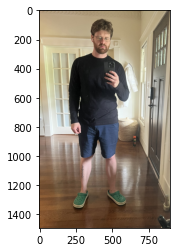

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img1 = mpimg.imread('gdrive/My Drive/blake.jpg')
imgplot = plt.imshow(img1)
plt.show()

In [ ]:
img1.shape

(1494, 894, 3)

In [ ]:
descs = []
im = Image.open("gdrive/My Drive/blake.jpg")
rectangle = [(0, 0), (img1.shape[1], img1.shape[0])]
metadata = detect_simple(im, rectangle)
d = metadata['DESCRIPTOR']
descs.append((d, 'blake'))

DESCRIPTOR
         [4, 0, 2, 1, 1, 1, 3, 0, 1, 2, 2, 2, 2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 2, 2, 3, 1, 0]
top to bottom time: 0.2794511318206787 seconds
averaging time: 0.003619670867919922 seconds


In [ ]:
labels = [
        'Average', 'Big', 'Broad-Shoulders', 'Built',
        'Curvy', 'Feminine', 'Fit', 'Heavyset', 'Lean',
        'Long-Legs', 'Long-Torso', 'Long', 'Masculine',
        'Muscular', 'Pear-Shaped', 'Petite', 'Proportioned',
        'Rectangular', 'Round-Apple', 'Short-Legs',
        'Short-Torso', 'Short', 'Skinny', 'Small', 'Stocky',
        'Sturdy', 'Tall', 'Attractive', 'Sexy', 'Hourglass',
    ]

a=0
for val in descs[0][0]:
  print ("%d  %s"  % (val, labels[a]))
  a+=1

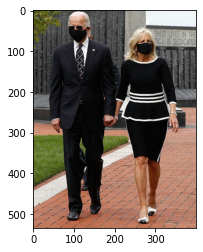

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('gdrive/My Drive/jill.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
img.shape[1]

400

In [ ]:
def load_csv(filename: str, sep=","):
    data: List[Dict[str, str]] = []
    titles = []
    with open(filename, "r") as f:
        lst = f.readlines()
        lf = []
        for item in lst:
            if item.strip() != "":
                lf.append(item.strip())
        titles = lf[0].split(sep)
        data = []
        for item in lf[1:]:
            vals = item.split(sep)
            d = {}
            for (h, v) in zip(titles, vals):
                d[h] = v
            data.append(d)

    return (data, titles)


# def norm(l):
#     return math.sqrt(sum([x**2 for x in l]))


def dist(l1, l2):
    return sum([abs(a-b) for (a, b) in zip(l1, l2)])


def descriptor(l1, l2):
    return ([abs(a-b) for (a, b) in zip(l1, l2)])


def recglob(directory: str, ext: str) -> List[str]:
    lst = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, ext):
            lst.append(os.path.join(root, filename))
    return lst


def main():
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.linear_model import SGDClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    clf = make_pipeline(
        StandardScaler(), SGDClassifier(
            tol=1e-3, random_state=0, verbose=1, early_stopping=True,
        ),
    )

    #sys.exit(0)
if __name__ == "__main__":
    sys.exit(main())
